In [1]:
# https://keras.io/examples/vision/object_detection_using_vision_transformer/

In [2]:
# !pip install -U tensorflow-addons

In [1]:
# from transformers import VisualBertModel
# model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
TF_ENABLE_ONEDNN_OPTS=0
CUDA_VISIBLE_DEVICES=""

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
import torch

2022-08-04 14:31:02.163669: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
from PIL import Image
import pickle
from os.path import exists


In [3]:
import sys
sys.path.append('../src')

from glosat_utils import *

[2022-08-04 14:31:04] Model res_unet18 initialisated with norm_layer=InstanceNorm2d({'momentum': 0.1, 'affine': True, 'track_running_stats': False}) and kwargs {'encoder_name': 'resnet18', 'reduced_layers': False, 'no_maxpool': False, 'conv_as_maxpool': True, 'use_deconv': True, 'use_upcatconv': False, 'use_conv1x1': False, 'pretrained_encoder': False}


In [4]:
img_directory = '/data/glosat/Code-Git/docformer/dataset/Finetuning/train/images'
annot_directory='/data/glosat/glosat_table_dataset/datasets/Train/table_bbox'

f = open(f'{annot_directory}/table_cell_bbox.pkl', 'rb')
training_set = pickle.load(f)
f.close()

In [5]:
# list of paths to images and annotations
image_paths = [
    os.path.join(img_directory, f+'.jpg') for f in training_set if os.path.isfile(os.path.join(img_directory, f+'.jpg'))
]

In [6]:
image_size = 1024  # resize input images to this size

img_idx, images, table_targets, table_info, cell_targets, cell_info = [], [], [], [], [], []

# loop over the annotations and images, preprocess them and store in lists
for f in training_set:
    cell_bboxes, cells_target, table_bboxes, table_target = [], [], [], []
    
    img_idx.append(f)
    
    # Access bounding box coordinates
    cells_annot, tables_annot = list(training_set[f])
    
    for cell in cells_annot:
        cell_bb, cell_class = cell
        cell_bboxes.append(cell_bb)
        cells_target.append(cell_class)
    
    for cell in tables_annot:
        cell_bb, cell_class = cell
        table_bboxes.append(cell_bb)
        table_target.append(cell_class)
        
    table_targets.append(table_target)
    table_info.append(table_bboxes)
    
    cell_targets.append(cells_target)
    cell_info.append(cell_bboxes)
    
    img_path = os.path.join(img_directory, f+'.jpg')
    image = keras.utils.load_img(img_path)
    
    ### Preprocessing of image ###
    open_cv_image = np.array(image) 
    image, h, w, c = image_preprocessing(open_cv_image)
    image = Image.fromarray(image)
    ### Preprocessing of image ###
    
    image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))

### Plot dataset samples

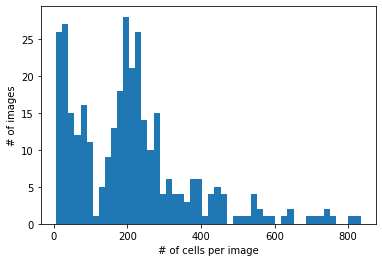

Maximum number of cells in an image: 834
Minimum number of cells in an image: 6
Average number of cells in an image: 209.3779761904762


In [7]:
fig, ax = plt.subplots()

ax.set_ylabel('# of images')
ax.set_xlabel('# of cells per image')

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True


# Plot the histogram
plt.hist([len(s) for s in cell_info], bins=50)

# Save the histogram
# plt.savefig('dataset/CLPsych_dataset/teamdata/training_dataset_new_histogram_post_timeline.pdf')

# Display the plot
plt.show()

x = [len(s) for s in cell_info]
print(f'Maximum number of cells in an image: {max(x)}')
print(f'Minimum number of cells in an image: {min(x)}')
print(f'Average number of cells in an image: {sum(x)/len(x)}')

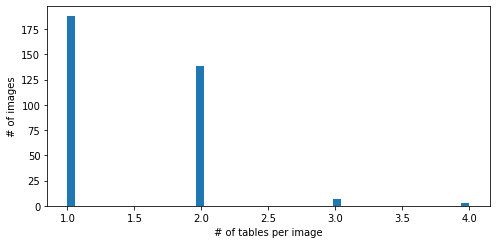

Maximum number of tables in an image: 4
Minimum number of tables in an image: 1
Average number of tables in an image: 1.4791666666666667


In [8]:
fig, ax = plt.subplots()

ax.set_ylabel('# of images')
ax.set_xlabel('# of tables per image')

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the histogram
plt.hist([len(s) for s in table_info], bins=50)

# Save the histogram
# plt.savefig('dataset/CLPsych_dataset/teamdata/training_dataset_new_histogram_post_timeline.pdf')

# Display the plot
plt.show()

x = [len(s) for s in table_info]
print(f'Maximum number of tables in an image: {max(x)}')
print(f'Minimum number of tables in an image: {min(x)}')
print(f'Average number of tables in an image: {sum(x)/len(x)}')

### make dataset

In [9]:
no_cells_per_image = 1000
no_tables_per_image = 6

table_info_full = []
table_target_full = []
for i, tables in enumerate(table_info):
    no_table = len(tables)
    blank_tables_bboxes = [[0,0,0,0]]*(no_tables_per_image-no_table)
    tables=tables+blank_tables_bboxes
    tables = np.asarray(tables)
    table_info_full.append(tables)
    
    table_target = table_targets[i]
    blank_tables_targets = [[0,1]]*(no_tables_per_image-no_table)
    table_target=table_target+blank_tables_targets
    table_target = np.asarray(table_target)
    table_target_full.append(table_target)
    
cells_info_full = []
cells_target_full = []
for i, cells in enumerate(cell_info):
    no_cells = len(cells)
    blank_cells_bboxes = [[0,0,0,0]]*(no_cells_per_image-no_cells)   # possible to add random cell generator
    cells=cells+blank_cells_bboxes
    cells = np.asarray(cells)
    cells_info_full.append(cells)
    
    cells_target = cell_targets[i]
    blank_cells_targets = [[0,0,0,1]]*(no_cells_per_image-no_cells)
    cells_target=cells_target+blank_cells_targets
    cells_target = np.asarray(cells_target)
    cells_target_full.append(cells_target)
    

In [10]:
# Convert the list to numpy array, split to train and test dataset
(x_train_ids), (x_train), (y_train_table_bboxes), (y_train_table_targets), (y_train_cell_bboxes), (y_train_cell_targets) = (
    img_idx[: int(len(images) * 0.8)],
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(table_info_full[: int(len(images) * 0.8)]),
    np.asarray(table_target_full[: int(len(images) * 0.8)]),
    np.asarray(cells_info_full[: int(len(images) * 0.8)]),
    np.asarray(cells_target_full[: int(len(images) * 0.8)]),
)

(x_test_ids), (x_test), (y_test_table_bboxes), (y_test_table_targets), (y_test_cell_bboxes), (y_test_cell_targets) = (
    img_idx[int(len(images) * 0.8) :],
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(table_info_full[int(len(images) * 0.8) :]),
    np.asarray(table_target_full[int(len(images) * 0.8) :]),
    np.asarray(cells_info_full[int(len(images) * 0.8) :]),
    np.asarray(cells_target_full[int(len(images) * 0.8) :]),
)

In [11]:
y_test_cell_targets.shape

(68, 1000, 4)

### Hyperparameters

In [12]:
no_cells_per_image = 1000
no_tables_per_image = 6

input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32

num_epochs = 100
projection_dim = 64
num_heads = 4

# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

history = []
image_size = 1024  # resize input images to this size
patch_size = 32  # Size of the patches to be extracted from the input images

num_patches = (image_size // patch_size) ** 2

### Modules

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

### Plot patches

In [ ]:
# patch_size = 32  # Size of the patches to be extracted from the input images
# patches = Patches(patch_size)(tf.convert_to_tensor([input_image]))
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# n = int(np.sqrt(patches.shape[1]))

# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

### Implement the patch encoding layer

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [104]:
def transformer_encoder_module(transformer_layers, num_heads, projection_dim,transformer_units,encoded_patches):
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        return encoded_patches

### Build the ViT model

In [112]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units):
    
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    encoded_patches = transformer_encoder_module(transformer_layers, num_heads, projection_dim,transformer_units,encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    cell_decode = layers.Dense(no_cells_per_image)(encoded_patches)
    table_decode = layers.Dense(no_tables_per_image)(encoded_patches)

    cell_decode = layers.Permute((2,1))(cell_decode)
    table_decode = layers.Permute((2,1))(table_decode)
    tables_image, table_feat_dim = table_decode.shape[1:]
    cells_image, cell_feat_dim = cell_decode.shape[1:]
    
    table_transformer_units = [
    table_feat_dim * 2,
    table_feat_dim,
    ]
    
    cell_transformer_units = [
    cell_feat_dim * 2,
    cell_feat_dim,
    ]
    
    cell_features = transformer_encoder_module(transformer_layers, num_heads, cell_feat_dim, cell_transformer_units,cell_decode)
    table_features = transformer_encoder_module(transformer_layers, num_heads, table_feat_dim, table_transformer_units,table_decode)

#     cell_features = mlp(cell_decode, hidden_units=mlp_head_units, dropout_rate=0.3)
#     table_features = mlp(table_decode, hidden_units=mlp_head_units, dropout_rate=0.3)

    cell_targets = layers.Dense(4, activation='softmax', name="cell_classes")(cell_features) 
    cell_bounding_box = mlp(cell_features, hidden_units=mlp_head_units, dropout_rate=0.3)
    cell_bounding_box = layers.Dense(4, activation='sigmoid', name="cell_bbox")(cell_bounding_box)  

    table_targets = layers.Dense(2, activation='softmax', name="table_classes")(table_features) 
    table_bounding_box = mlp(table_features, hidden_units=mlp_head_units, dropout_rate=0.3)
    table_bounding_box = layers.Dense(4, activation='sigmoid', name="table_bbox")(table_bounding_box)
    
    # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=[table_targets,table_bounding_box,cell_targets, cell_bounding_box])


In [105]:
# inputs = layers.Input(shape=input_shape)
# # Create patches
# patches = Patches(patch_size)(inputs)
# # Encode patches
# encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

# encoded_patches = transformer_encoder_module(transformer_layers, num_heads, projection_dim,transformer_units,encoded_patches)

# # Create a [batch_size, projection_dim] tensor.
# representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
# cell_decode = layers.Dense(no_cells_per_image)(encoded_patches)
# table_decode = layers.Dense(no_tables_per_image)(encoded_patches)

# cell_decode = layers.Permute((2,1))(cell_decode)
# table_decode = layers.Permute((2,1))(table_decode)
# tables_image, table_feat_dim = table_decode.shape[1:]
# cells_image, cell_feat_dim = cell_decode.shape[1:]

# table_transformer_units = [
# table_feat_dim * 2,
# table_feat_dim,
# ]

# cell_transformer_units = [
# cell_feat_dim * 2,
# cell_feat_dim,
# ]

# cell_features = transformer_encoder_module(transformer_layers, num_heads, cell_feat_dim, cell_transformer_units,cell_decode)
# table_features = transformer_encoder_module(transformer_layers, num_heads, table_feat_dim, table_transformer_units,table_decode)

# #     cell_features = mlp(cell_decode, hidden_units=mlp_head_units, dropout_rate=0.3)
# #     table_features = mlp(table_decode, hidden_units=mlp_head_units, dropout_rate=0.3)

# cell_targets = layers.Dense(4, activation='softmax', name="cell_classes")(cell_features) 
# cell_bounding_box = layers.Dense(4, activation='sigmoid', name="cell_bbox")(cell_features)  

# table_targets = layers.Dense(2, activation='softmax', name="table_classes")(table_features) 
# table_bounding_box = layers.Dense(4, activation='sigmoid', name="table_bbox")(table_features)  

In [100]:
# cell_transformer_units = [
# cell_feat_dim * 2,
# cell_feat_dim,
# ]

# cell_features = transformer_module(transformer_layers, num_heads, cell_feat_dim, cell_transformer_units,cell_decode)
# cell_features.shape

TensorShape([None, 1000, 1024])

In [105]:
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError

In [106]:
losses = {
        "cell_classes": "categorical_crossentropy",
        "cell_bbox": "mean_absolute_error", #keras.losses.MeanAbsoluteError(),
        "table_classes": "categorical_crossentropy",
        "table_bbox": "mean_absolute_error" #keras.losses.MeanAbsoluteError()
        }

lossWeights = {"cell_classes": 1, "cell_bbox": 1, "table_classes": 1, "table_bbox": 1}  # Weightage for optimizing the error loss

### Run the experiment

In [113]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
# #     lr=0.001
#     radam = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
#     ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
#     optimizer = ranger

    # Compile model.
#     model.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
    model.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy", MeanAbsolutePercentageError()])

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(
        x=x_train,
        y=[y_train_table_targets, y_train_table_bboxes, y_train_cell_targets, y_train_cell_bboxes],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

In [108]:
y_test_table_bboxes[0][0]

array([0.51428665, 0.89300121, 0.94742225, 0.14111956])

In [114]:
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

In [70]:
model_loc = '/data/glosat/Code-Git/docExtractor-master/demo/model'

if exists(f"{model_loc}/vit_object_detector-v2.h5"):
    vit_object_detector.load_weights(f"{model_loc}/vit_object_detector-v2.h5")
    print('Model loaded')


Model loaded


In [ ]:
# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
8/8 [==============================] - 70s 8s/step - loss: 518.5287 - table_classes_loss: 380.9038 - table_bbox_loss: 0.4977 - cell_classes_loss: 137.0124 - cell_bbox_loss: 0.1148 - table_classes_accuracy: 0.7102 - table_classes_mean_absolute_percentage_error: 138495888.0000 - table_bbox_accuracy: 0.5754 - table_bbox_mean_absolute_percentage_error: 345914656.0000 - cell_classes_accuracy: 0.3484 - cell_classes_mean_absolute_percentage_error: 161278816.0000 - cell_bbox_accuracy: 0.7738 - cell_bbox_mean_absolute_percentage_error: 48668280.0000 - val_loss: 198.9955 - val_table_classes_loss: 116.1281 - val_table_bbox_loss: 0.4632 - val_cell_classes_loss: 82.3475 - val_cell_bbox_loss: 0.0566 - val_table_classes_accuracy: 0.9012 - val_table_classes_mean_absolute_percentage_error: 49382716.0000 - val_table_bbox_accuracy: 0.7654 - val_table_bbox_mean_absolute_percentage_error: 333333376.0000 - val_cell_classes_accuracy: 0.4690 - val_cell_classes_mean_absolute_percentage_error: 13266

In [60]:
# Saves the model in current path
vit_object_detector.save(f"{model_loc}/vit_object_detector-v2.h5", save_format="h5")

### Evaluate the model

In [78]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (box_truth[3] - box_truth[1] + 1)

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


In [79]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    n_img = 0
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f} {n_img}'
        n_img+=1
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Normalized the bounding box img_w, img_h = im_pil.size
def get_normalized_bbox(b, img_w, img_h):
    x0,y0,x1,y1 = b
    w = (x1-x0)/img_w
    h = (y1-y0)/img_h
    x_c =  (x0/img_w)+0.5*w
    y_c =  (y0/img_h)+0.5*h
    return [x_c,y_c,w,h]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
#     img = transform(im).unsqueeze(0)

#     # demo model only support by default images with aspect ratio between 0.5 and 2
#     # if you want to use images with an aspect ratio outside this range
#     # rescale your image so that the maximum size is at most 1333 for best results
#     assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
    
    inputs = feature_extractor(images=im, return_tensors="pt")
    outputs = model(**inputs)

    # propagate through the model
#     outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [80]:
input_image = x_train[0]
x_train_ids[0]

'412'

1/1 [==============================] - 0s 447ms/step


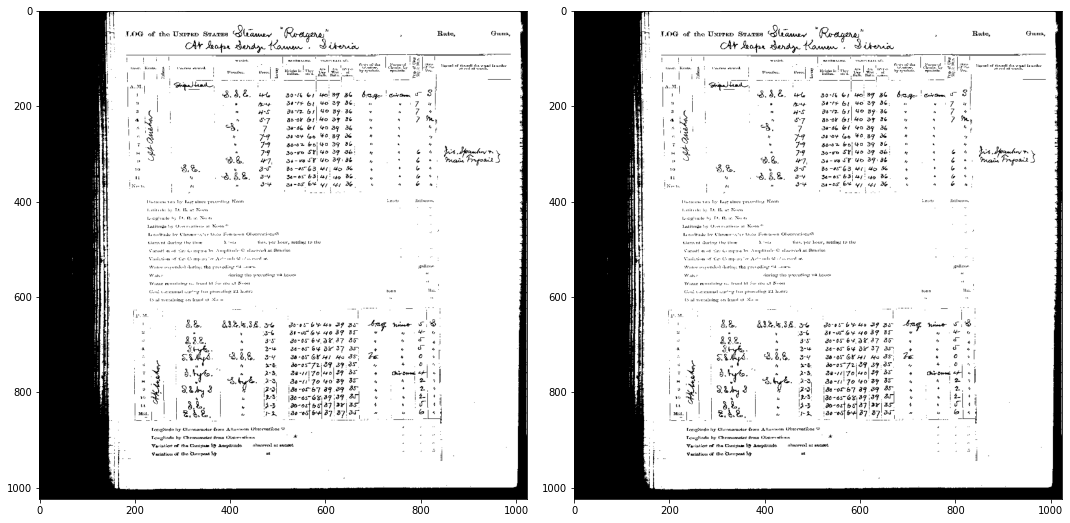

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
im = input_image

# Display the image
ax1.imshow(im.astype("uint8"))
ax2.imshow(im.astype("uint8"))

input_image = cv2.resize(
    input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
)
input_image = np.expand_dims(input_image, axis=0)
preds = vit_object_detector.predict(input_image)

In [82]:
[table_targets_out,table_bbox_out,cell_targets_out, cell_bbox_out] = preds

In [83]:
y_train_table_targets[1],y_train_table_bboxes[1]

(array([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]]),
 array([[0.57706882, 0.22872696, 0.7959506 , 0.28025867],
        [0.50922146, 0.72433827, 0.63584748, 0.22810709],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]))

In [101]:
table_targets_out[0],table_bbox_out[0]

(array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32))

In [102]:
table_bboxes_scaled = rescale_bboxes(torch.tensor(table_bbox_out[0], dtype=torch.float32), (height, width))
table_bboxes_scaled

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

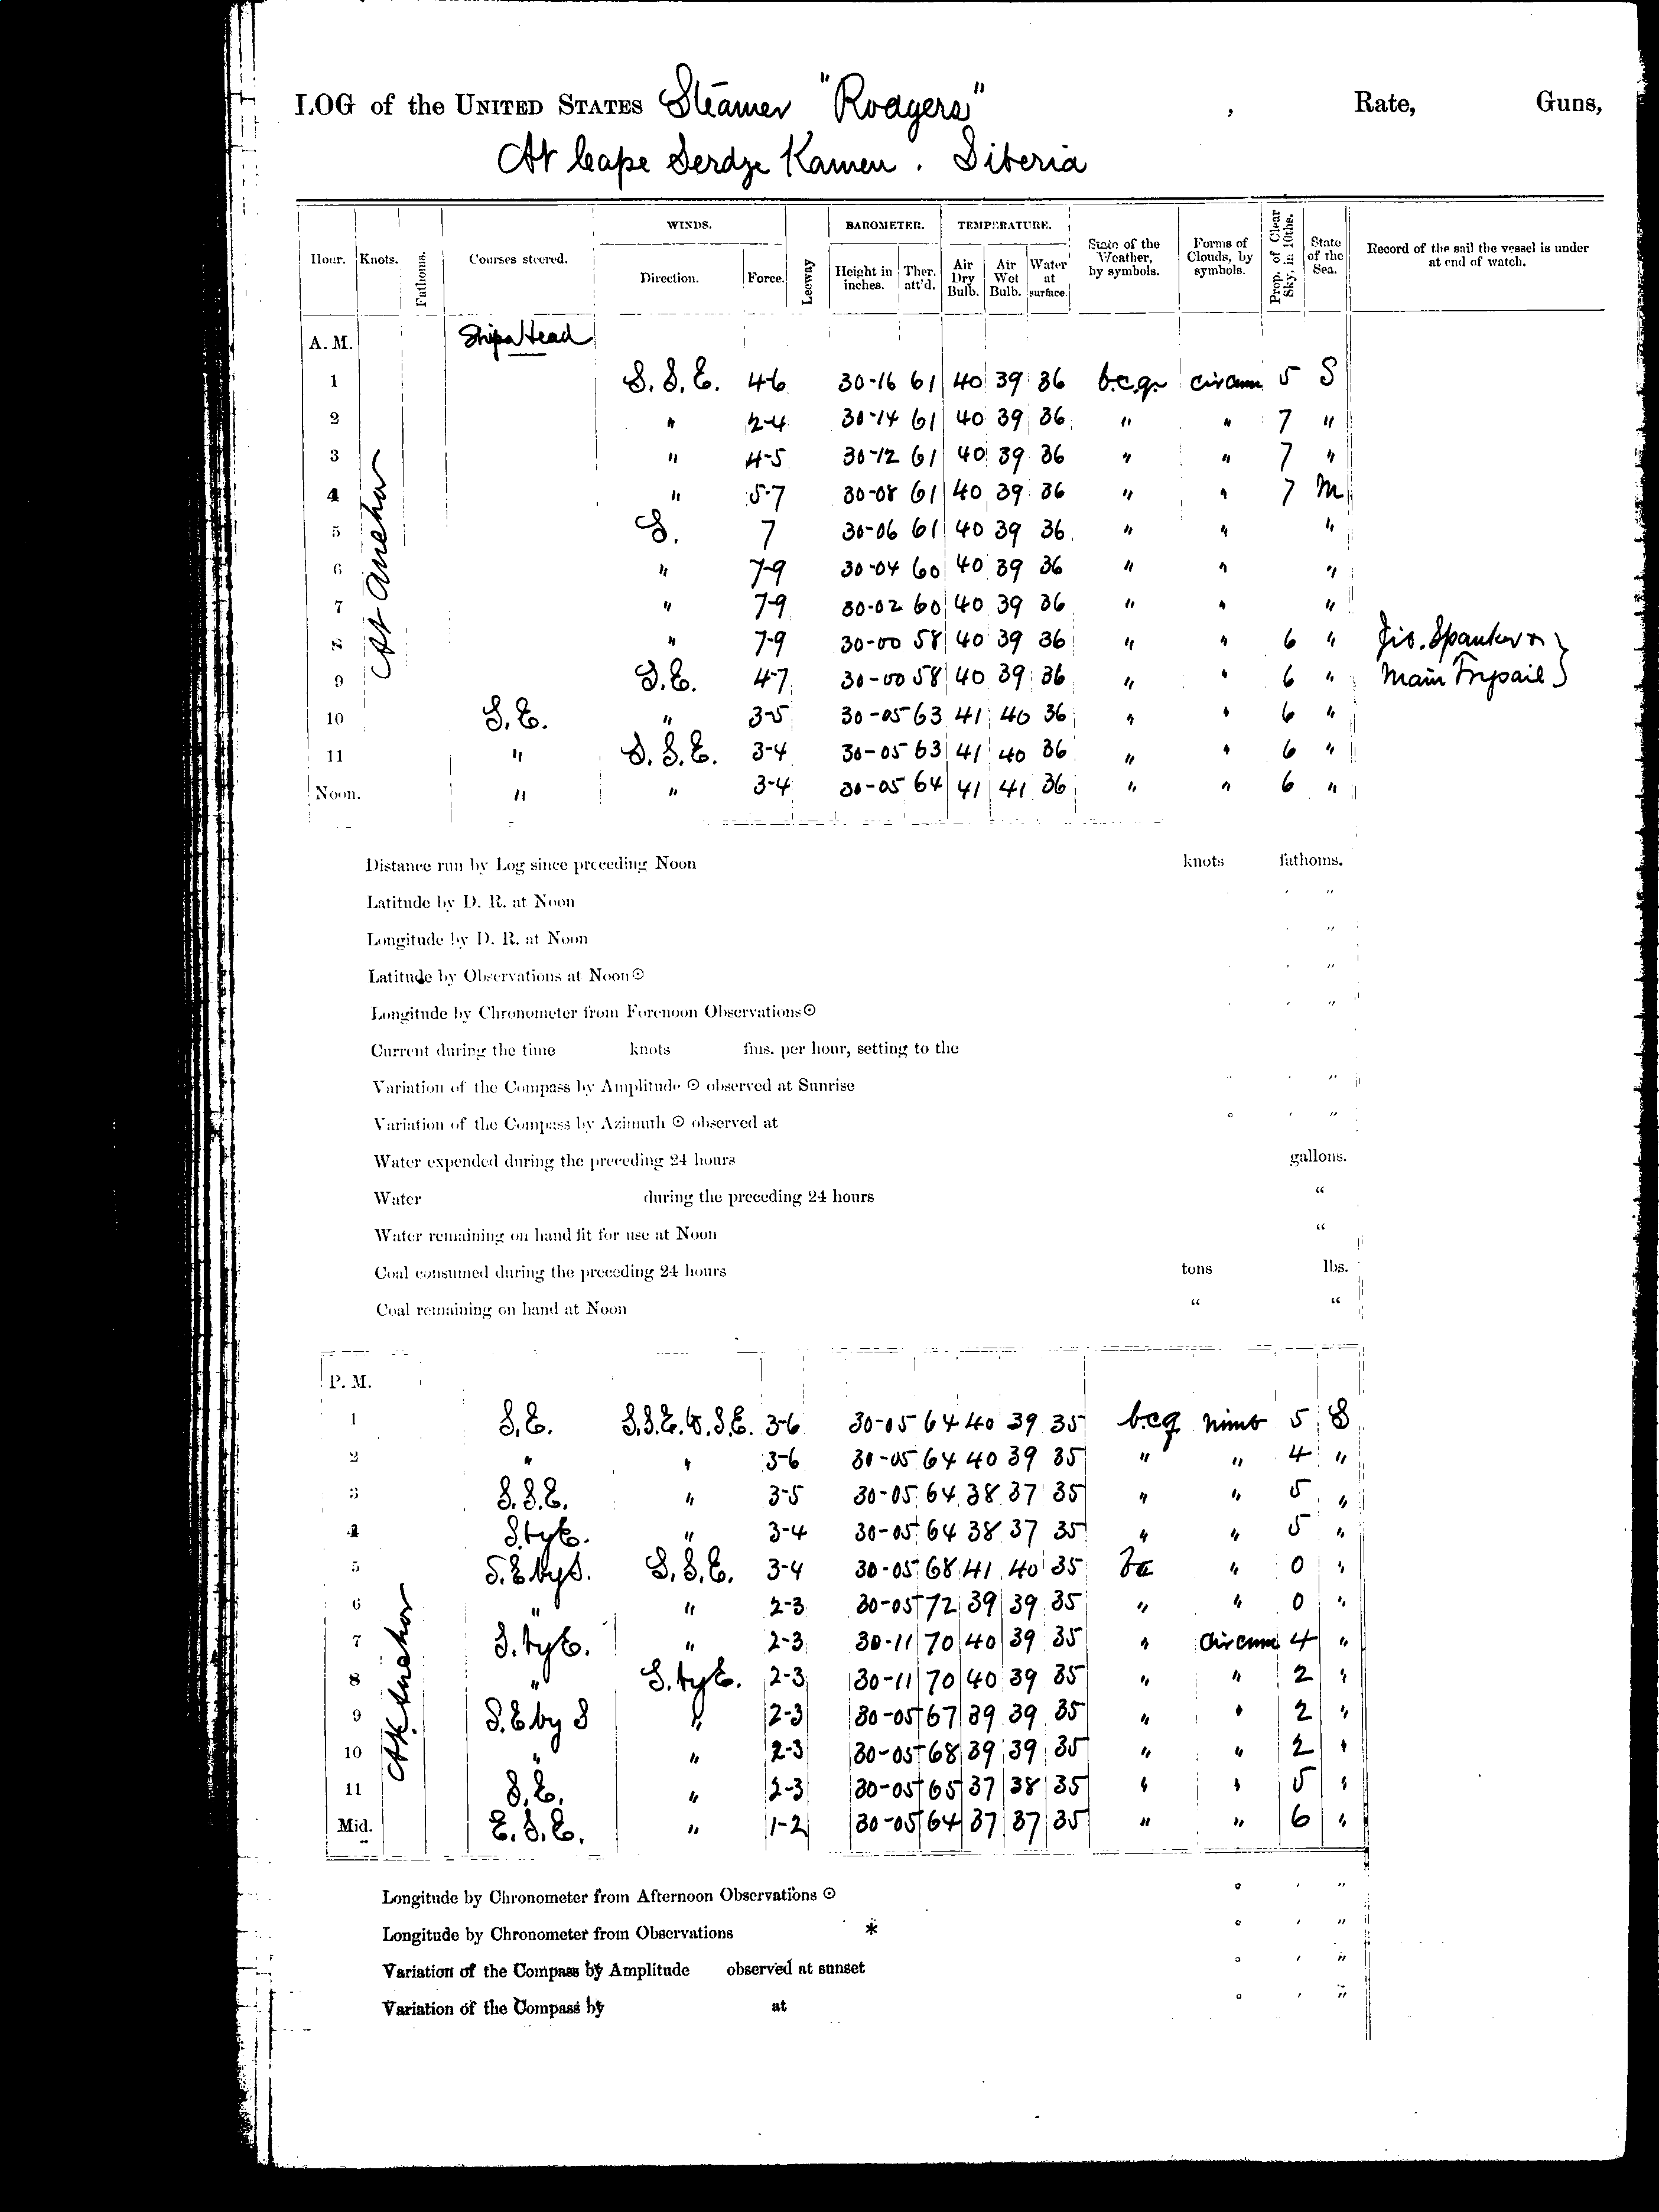

In [99]:
img = cv.imread(f'{img_directory}/{x_train_ids[0]}.jpg')
image, height, width, _ = image_preprocessing(img)
table_bboxes_scaled = rescale_bboxes(torch.tensor(table_bbox_out[0], dtype=torch.float32), (height, width))
color = 255
for box in [table_bboxes_scaled[1].tolist()]:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

im_pil = Image.fromarray(image)
im_pil  

In [100]:
table_bboxes_scaled

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

### Unseen image

In [24]:
img_directory = '/data/glosat/Code-Git/docformer/dataset/Finetuning/test/images'
annot_directory='/data/glosat/glosat_table_dataset/datasets/Test/table_bbox'

f = open(f'{annot_directory}/table_cell_bbox.pkl', 'rb')
testing_set = pickle.load(f)
f.close()

In [26]:
# list of paths to images and annotations
image_paths = [
    os.path.join(img_directory, f+'.jpg') for f in testing_set if os.path.isfile(os.path.join(img_directory, f+'.jpg'))
]

image_size = 1024  # resize input images to this size
img_idx, images, table_targets, table_info, cell_targets, cell_info = [], [], [], [], [], []

# loop over the annotations and images, preprocess them and store in lists
for f in testing_set:
    cell_bboxes, cells_target, table_bboxes, table_target = [], [], [], []
    
    img_idx.append(f)
    
    # Access bounding box coordinates
    cells_annot, tables_annot = list(testing_set[f])
    
    for cell in cells_annot:
        cell_bb, cell_class = cell
        cell_bboxes.append(cell_bb)
        cells_target.append(cell_class)
    
    for cell in tables_annot:
        cell_bb, cell_class = cell
        table_bboxes.append(cell_bb)
        table_target.append(cell_class)
        
    table_targets.append(table_target)
    table_info.append(table_bboxes)
    
    cell_targets.append(cells_target)
    cell_info.append(cell_bboxes)
    
    img_path = os.path.join(img_directory, f+'.jpg')
    image = keras.utils.load_img(img_path)
    
    ### Preprocessing of image ###
    open_cv_image = np.array(image) 
    image, h, w, c = image_preprocessing(open_cv_image)
    image = Image.fromarray(image)
    ### Preprocessing of image ###
    
    image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))

[21.37158203125, 75.98089599609375, 231.30105590820312, 170.6533966064453]

In [ ]:

i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()
